<font size="3"> This Notebook synthesizes data then tests the function `inv.inv_opening_positivity()`. </font>

In [1]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import matplotlib
import h5py
from vmod import util

from vmod.source import Regsill
from vmod.inverse import Inverse

In [2]:
# some parameters for this test; you can change any of them
#   nl: number of segments in length direction
#   nl: number of segments in length direction
#   xcenter, ycenter, depth [m]: location of fault center
#   strike, dip [deg]: fault parameters, shared by all patches
#   length [m]: fault length (along strike line)
#   width [m]: fault width (along dip line)
#   sigma [m/yr]: deformation uncertainty
nl      = 10 
nw      = 10
xcenter = 0
ycenter = 0
depth   = 5000
strike  = 95
dip     = 85
length  = 10000
width   = 2500
sigma   = 0.01

In [3]:
# this function helps in setting the colormap limits for the figures
# if not arr:
#   raise ValueError("Input array must not be empty.")
def get_lim(arr):
    max_abs_val = abs(arr[0])
    for elem in arr:
        max_abs_val = max(max_abs_val, abs(elem))
    return max_abs_val

<br>
<font size="3"> Read in an exsiting data csv for test. 

We will later synthesize the deformation, while other types of information (data structures, lons, lats, azimuths, ...) come from this file. </font>

In [4]:
from vmod.data import Insar
csvfile_ref = 'examples/insar/tanaga59_ref.csv'
obs         = Insar()
obs.importcsv(csvfile_ref,ori=[-178.14,51.85])
print(np.mean(obs.az)) 

3.3061825210297417


<br>
<font size="3"> Initialize an openning setting. 

The location of an entry in matrix is same to the location of the corresponding fault segment on the fault. The values are in meters [m]. 

you can set your own test openning matrix. Just make sure the size of the matrix fits your `nl` and `nw` values in previous cells.</font>

In [5]:
# just an example. change to your prefered values
syn_opening = np.zeros((10, 10))
syn_opening[3:7, 3:7] = 5
syn_opening[4:6, 4:6] = 10
print(syn_opening)
syn_opening = syn_opening.flatten()

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  5.  5.  5.  5.  0.  0.  0.]
 [ 0.  0.  0.  5. 10. 10.  5.  0.  0.  0.]
 [ 0.  0.  0.  5. 10. 10.  5.  0.  0.  0.]
 [ 0.  0.  0.  5.  5.  5.  5.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


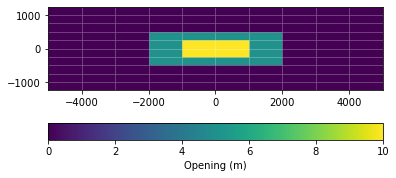

plotting length (m): 10000
plotting width (m):2500


In [6]:
# plot your openning setting
reg = Regsill(obs,typ='open',ln=nl,wn=nw)
reg.set_bounds(low_bounds =  [0, 0, 0, 0, 0, 0, 0, 0], \
               high_bounds = [0, 0, 0, 0, 0, 0, 0, 0])
inv=Inverse(obs)
inv.register_source(reg)

reg.plot_patches(length,width,syn_opening)

<font size="3"> Calculate and plot the synthetic deformation. </font>

In [7]:
oks,params = reg.get_reg_sill(xcenter,ycenter,depth,length,width,strike,dip,syn_opening)

inv = Inverse(obs)
for ok in oks:
    inv.register_source(ok)
syn_deformation=inv.forward(params,unravel=False)

obs.add_comp(syn_deformation[0],'los')

This component was already included; it will be replaced


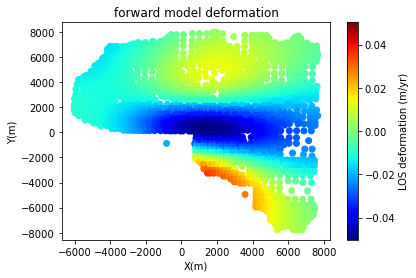

In [8]:
%matplotlib inline
plt.figure()
plt.title('forward model deformation')
data = obs.get_data()
plt.scatter( obs.xs,obs.ys,c=data,cmap='jet',vmin=-get_lim(data),vmax=get_lim(data) )
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.colorbar(label='LOS deformation (m/yr)')
plt.show()

In [9]:
syn_noise = np.random.uniform(-sigma, sigma, len(syn_deformation[0]))
syn_deformation_n = syn_deformation[0] + syn_noise
obs.add_comp(syn_deformation_n,'los')

This component was already included; it will be replaced


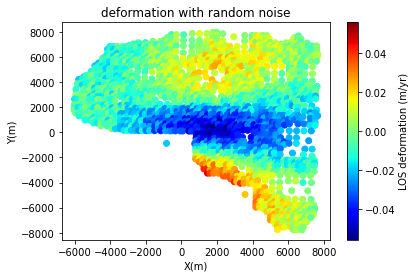

In [10]:
plt.figure()
plt.title('deformation with random noise')
data = obs.get_data()
plt.scatter( obs.xs,obs.ys,c=data,cmap='jet',vmin=-get_lim(data),vmax=get_lim(data) )
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.colorbar(label='LOS deformation (m/yr)')
plt.show()

<br>
<font size="3"> 
    
Run an inversion. Arguement `reg` ( `False` or `True` ) controls regularization.

`lamb` only works when `reg` is set to `True`. </font>

In [27]:
lamb = 10e75

reg = Regsill(obs,typ='open',ln=10,wn=10)
reg.set_bounds(low_bounds =  [0, 0, 0, 0, 0, 0, 0, 0], \
               high_bounds = [0, 0, 0, 0, 0, 0, 0, 0])
inv=Inverse(obs)
inv.register_source(reg)

ops=inv.inv_opening_positivity(xcenter,ycenter,depth,length,width,strike,dip,reg=True,lamb=lamb)
print('inverse success: '+str(ops.success))
ops = ops.x

inverse success: True


In [28]:
oks,params=reg.get_reg_sill(xcenter,ycenter,depth,length,width,strike,dip,ops)

inv=Inverse(obs)
for ok in oks:
    inv.register_source(ok)
los_model=inv.forward(params,unravel=False)

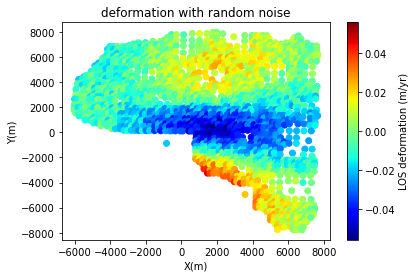

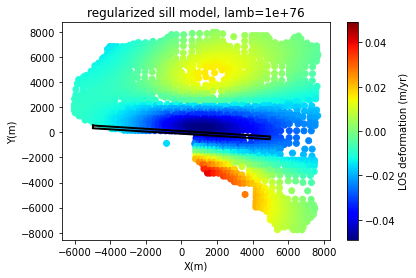

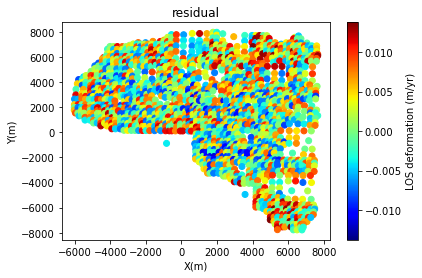

In [29]:
plt.figure()
plt.title('deformation with random noise')
data = obs.get_data()
plt.scatter( obs.xs,obs.ys,c=data,cmap='jet',vmin=-get_lim(data),vmax=get_lim(data) )
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.colorbar(label='LOS deformation (m/yr)')
plt.show()

plt.figure()
plt.title('regularized sill model, lamb='+str(lamb))
data = los_model[0]
plt.scatter( obs.xs,obs.ys,c=data,cmap='jet',vmin=-get_lim(data),vmax=get_lim(data) )
[x1,y1,z1],[x2,y2,z2],[x3,y3,z3],[x4,y4,z4] = reg.rotate_xyz(xcenter,ycenter,depth,length,width,strike,dip)
plt.plot([x1,x2,x3,x4,x1],[y1,y2,y3,y4,y1],color='black',linestyle='-',linewidth=2)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.colorbar(label='LOS deformation (m/yr)')

plt.figure()
plt.title('residual')
data = obs.get_data()-los_model[0]
plt.scatter( obs.xs,obs.ys,c=data,cmap='jet',vmin=-get_lim(data),vmax=get_lim(data) )
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.colorbar(label='LOS deformation (m/yr)')

<br>
<font size="3"> 
    
Plot and compare the synthetic openning and the inversed opening. </font>

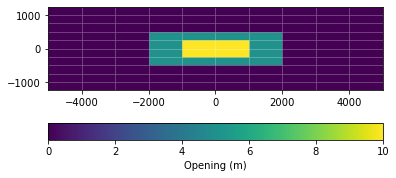

plotting length (m): 10000
plotting width (m):2500


In [30]:
reg.plot_patches(length,width,syn_opening)

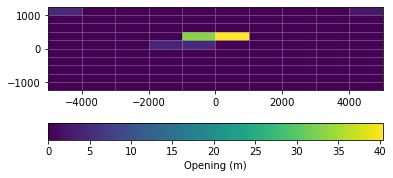

plotting length (m): 10000
plotting width (m):2500


In [31]:
reg.plot_patches(length,width,ops)

<font size="3">
We can see that due to the non-uniqueness of the inversion problem, it is not guaranteed to obtain the correct openning. Incorrect values can also produce a highly consistent deformation signal. 

<br>

By adjusting the value of `lamb`, we can partly control the inversion process. </font>